In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [2]:
df = (
    pd.read_csv('data.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [3]:
# Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

# Логарифмируем таргет для будущей оптимизации
# MSLE через MSE

log_target = np.log1p(y)

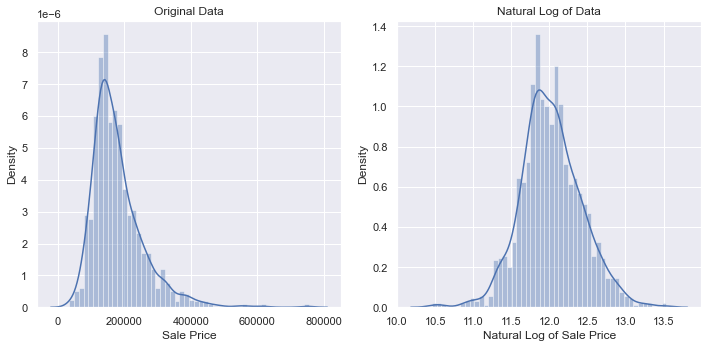

In [4]:
# Это позволяет получить нормальное распределение таргета
# Важно, например, для построения корректной
# С точки зрения статистических свойств
# Линейной модели.
# Хотя здесь мы будем строить ансамбли деревьев, 
# И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%.

In [5]:
X.isna().mean().sort_values(ascending=False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
                   ...   
Heating          0.000000
MSZoning         0.000000
CentralAir       0.000000
1stFlrSF         0.000000
SaleCondition    0.000000
Length: 79, dtype: float64

In [6]:
X = X.drop(X.loc[:, X.isna().mean() > 0.15].columns, axis=1)

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные, а затем переведите в строки.

In [7]:
X[['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']] = \
X[['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']].astype(object)

In [8]:
numeric_cols = X.loc[:, X.dtypes != object].columns
categorical_cols = X.loc[:, X.dtypes == object].columns

In [9]:
for col in X.columns:
    if col in numeric_cols:
        X[col] = X[col].fillna(X[col].median())
    else:
        most_freq = X[col].value_counts(ascending=False).index[0]
        X[col] = X[col].fillna(most_freq)

In [10]:
# Пропусков нет

X.isna().sum().sum()

0

In [11]:
X.to_csv('output1.csv', sep=',', index=False)

In [12]:
# Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [13]:
ohe_cols = [col for col in categorical_cols if X_train[col].nunique() < 5]
mte_cols = [col for col in categorical_cols if col not in ohe_cols]

ohe_cols_idx = [X_train.columns.get_loc(col) for col in ohe_cols]
mte_cols_idx = [X_train.columns.get_loc(col) for col in mte_cols]
numeric_cols_idx = [X_train.columns.get_loc(col) for col in numeric_cols]

In [14]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler


t = [('OneHotEncoder', OneHotEncoder(), ohe_cols_idx),
     ('TargetEncoder', TargetEncoder(), mte_cols_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transformer = ColumnTransformer(t)

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель.

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_tree = Pipeline([('transformer', col_transformer), ('dt', DecisionTreeRegressor())])
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 37, 38, 50, 56,
                                                   61]),
                                                 ('TargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 16,
                                                   17, 18, 19, 20, 21, 25, 26,
                                                   30, 32, 36, 39, 52, 54, 55,
                                                   59, 60, 69, 70, 71, 72]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                       

In [16]:
from sklearn.metrics import mean_squared_error

print(f'Train MSLE: {mean_squared_error(y_train, pipe_tree.predict(X_train)):.4}')
print(f'Test MSLE: {mean_squared_error(y_test, pipe_tree.predict(X_test)):.4}')

Train MSLE: 8.645e-33
Test MSLE: 0.04411


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [17]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_random_forest = Pipeline([('tranformer', col_transformer),
                               ('random_forest', RandomForestRegressor())])

search_rf = GridSearchCV(pipe_random_forest, param_grid, return_train_score=True)
search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tranformer',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 22,
                                                                          24,
                                                                          27,
                                                                          28,
                                                                          29,
                                                                          37,
                                                                          38,
                                                         

In [18]:
print(f'Test MSLE: {mean_squared_error(y_test, search_rf.predict(X_test)):.3}')

Test MSLE: 0.0183


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

base_pipe_lr = Pipeline([('transformer', col_transformer), ('lr', LinearRegression())])
base_pipe_dt = Pipeline([('transformer', col_transformer), ('dt', DecisionTreeRegressor())])
base_pipe_rf = Pipeline([('transformer', col_transformer), ('rf', RandomForestRegressor())])

In [20]:
# Linear Regression

bagging_lr = BaggingRegressor(base_estimator=base_pipe_lr, 
                              n_estimators=100, 
                              random_state=1)

bagging_lr.fit(X_train, y_train)

print(f'Train MSLE: {mean_squared_error(y_train, bagging_lr.predict(X_train)):.4}')
print(f'Test MSLE: {mean_squared_error(y_test, bagging_lr.predict(X_test)):.4}')

Train MSLE: 1.769e+19
Test MSLE: 7.276e+19


In [21]:
# Decision tree

bagging_dt = BaggingRegressor(base_estimator=base_pipe_dt, 
                              n_estimators=100, 
                              random_state=1)

bagging_dt.fit(X_train, y_train)

print(f'Train MSLE: {mean_squared_error(y_train, bagging_dt.predict(X_train)):.4}')
print(f'Test MSLE: {mean_squared_error(y_test, bagging_dt.predict(X_test)):.4}')

Train MSLE: 0.003062
Test MSLE: 0.01844


In [22]:
# Random forest

bagging_rf = BaggingRegressor(base_estimator=base_pipe_rf, 
                              n_estimators=100, 
                              random_state=1)

bagging_rf.fit(X_train, y_train)

print(f'Train MSLE: {mean_squared_error(y_train, bagging_rf.predict(X_train)):.4}')
print(f'Test MSLE: {mean_squared_error(y_test, bagging_rf.predict(X_test)):.4}')

Train MSLE: 0.006003
Test MSLE: 0.01916


Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [23]:
# Отношения площади 1 этажа к общей площади
X['feature_1'] = (X['1stFlrSF'] / X['GrLivArea']) * 100

# Отношение Площади завершенного фундамента первого типа к общей площади фундамента
X['feature_2'] = X.apply(
    lambda x: x['BsmtFinSF1'] * 100 / x['TotalBsmtSF'] if x['TotalBsmtSF'] != 0 else 0, axis=1)

# Возраст дома
X['feature_3'] = (X['YrSold'] - X['YearBuilt'].astype(int)).astype(int)

# Общая площадь самого дома и фундамента/цоколя
X['feature_4'] = X['1stFlrSF'] + X['2ndFlrSF'] + X['TotalBsmtSF']

X_train, X_test, y_train, y_test = train_test_split(X, log_target, test_size=0.25, random_state=1)

In [24]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_random_forest = Pipeline([('tranformer', col_transformer),
                               ('random_forest', RandomForestRegressor())])

search_rf = GridSearchCV(pipe_random_forest, param_grid, 
                         return_train_score=True, 
                         scoring='neg_mean_squared_error')
search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tranformer',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 22,
                                                                          24,
                                                                          27,
                                                                          28,
                                                                          29,
                                                                          37,
                                                                          38,
                                                         

In [25]:
print(f'Test MSLE: {mean_squared_error(y_test, search_rf.predict(X_test)):.3}')

Test MSLE: 0.0182
